## Face Similarity Matching, the basis our our Face Classifier

In this section, we will load a pre-trained model of VGGFace (trainined on thousands of faces) and use it, together with a similarity metric, to define whether two faces are of the same person

In [1]:
# Import our libaries
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from PIL import Image
import numpy as np
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Define our VGGFace Model

In [3]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

## Load out VGG Face Weights

In [4]:
#you can download the pretrained weights from the following link 
#https://drive.google.com/file/d/1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo/view?usp=sharing
#or you can find the detailed documentation https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

from keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

## Define our very important findCosineSimilarity function.
We also load our findEuclideanDistance() function and will show the distance metric used to create a similarity score between the faces under comparison 

In [5]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))


vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

## Define our verifyFace function where we load to images of faces and compare them.

We set **epsilon** to be the threshold of whether our two faces are the same person. Setting a lower value makes it more strict with our face matching.

In [20]:
epsilon = 0.40

def verifyFace(img1, img2):
    img1_representation = vgg_face_descriptor.predict(preprocess_image('./training_faces/%s' % (img1)))[0,:]
    img2_representation = vgg_face_descriptor.predict(preprocess_image('./training_faces/%s' % (img2)))[0,:]
    
    cosine_similarity = findCosineSimilarity(img1_representation, img2_representation)
    
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(image.load_img('./training_faces/%s' % (img1)))
    plt.xticks([]); plt.yticks([])
    f.add_subplot(1,2, 2)
    plt.imshow(image.load_img('./training_faces/%s' % (img2)))
    plt.xticks([]); plt.yticks([])
    plt.show(block=True)
    
    print("Cosine similarity: ",cosine_similarity)
    
    if(cosine_similarity < epsilon):
        print("They are same person")
    else:
        print("They are not same person!")

## Let's a run a few tests

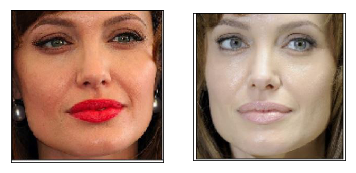

Cosine similarity:  0.2544904947280884
They are same person


In [21]:
# Let's compare two faces images of Angelina Jolie
verifyFace("angelina.jpg", "angelina2.jpg")

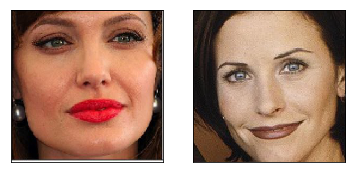

Cosine similarity:  0.4739534854888916
They are not same person!


In [22]:
# Let's now compare it to the Friends character Monica, it should return that these are two different people
verifyFace("angelina.jpg", "Monica.jpg")

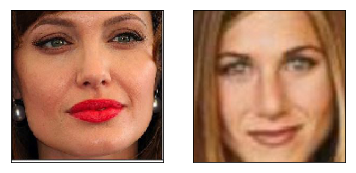

Cosine similarity:  0.7327100932598114
They are not same person!


In [23]:
# Let's try it with Rachel
verifyFace("angelina.jpg", "Rachel.jpg")

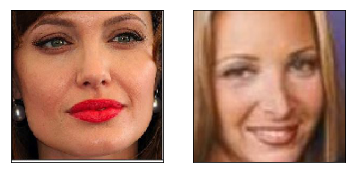

Cosine similarity:  0.6882018446922302
They are not same person!


In [24]:
# And now Pheobe
verifyFace("angelina.jpg", "Pheobe.jpg")

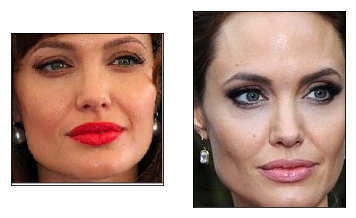

Cosine similarity:  0.38444703817367554
They are same person


In [25]:
# Now let's try it with another image of Angelina Jolie
verifyFace("angelina.jpg", "angelina3.jpg")

### There we see that our Face Matcher is working quite well as it's able to distinguish Angelina Jolie from other actresses